In [29]:
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt #for plotting
import cartopy.crs as ccrs #for map projection
import cartopy.feature as cfeature #adding features to the map
import numpy as np 

In [ ]:
path = r"D:\OneDrive\Desktop\Landuse Modelling"
input_path = path + r"\data\copernicus_raster100m\DATA\U2018_CLC2018_V2020_20u1.tif"
output_path = path + r"output\aggregated_landuse_classes.nc"

In [23]:
da = rxr.open_rasterio(input_path, chunks={'x': 1000, 'y': 1000}).squeeze()  # 1. Band, 2D
da.rio.write_crs("EPSG:3035", inplace=True)
da_wgs84 = da.rio.reproject("EPSG:4326")
# Bounding Box für Deutschland in EPSG:3035 (Meter)
min_x, max_x = 5.5, 15.5
min_y, max_y = 47, 55

# Zuschneiden auf Deutschland
da_de = da_wgs84.rio.clip_box(minx=min_x, maxx=max_x, miny=min_y, maxy=max_y)

In [24]:
da_de

<xarray.DataArray (y: 6249, x: 7810)> Size: 49MB
array([[-128, -128, -128, ...,   44,   44,   44],
       [-128, -128, -128, ...,   44,   44,   44],
       [-128, -128, -128, ...,   44,   44,   44],
       ...,
       [  23,   23,   23, ...,   12,   12,   12],
       [  23,   23,   23, ...,   12,   12,   12],
       [  23,   23,   23, ...,   12,   12,   12]],
      shape=(6249, 7810), dtype=int8)
Coordinates:
  * x            (x) float64 62kB 5.5 5.501 5.502 5.504 ... 15.5 15.5 15.5 15.5
  * y            (y) float64 50kB 55.0 55.0 55.0 55.0 ... 47.0 47.0 47.0 47.0
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes: (12/13)
    AREA_OR_POINT:           Area
    DataType:                Thematic
    RepresentationType:      THEMATIC
    STATISTICS_COVARIANCES:  136.429646247598
    STATISTICS_MAXIMUM:      48
    STATISTICS_MEAN:         25.753373398066
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       11.680310194836
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              -128

MemoryError: Unable to allocate 1.54 GiB for an array with shape (68920885, 3) and data type float64

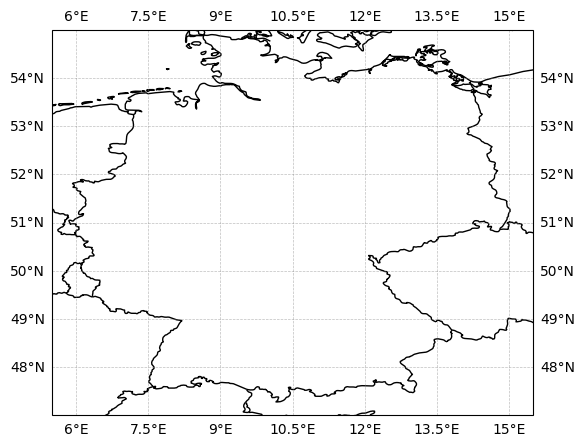

In [17]:
# Sometimes Plotting, Sometimes memory error
fig, ax = plt.subplots(1, 1, figsize=(50, 5), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
ax.set_extent([5.5, 15.5, 47, 55], crs=ccrs.PlateCarree())

daDe.plot(ax=ax, cmap='terrain', vmin=0, vmax=48)
plt.show()

In [39]:
np.unique(da_de.values[~np.isnan(da_de.values)]).astype(int)

array([-128,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   15,   16,   18,   20,   21,   22,   23,   24,   25,
         26,   27,   29,   30,   31,   32,   34,   35,   36,   37,   39,
         40,   41,   42,   43,   44])

In [ ]:
#Sort the 44 Classes in broader ones, based on https://land.copernicus.eu/en/technical-library/clc-product-user-manual/@@download/file

lookup = np.zeros(256, dtype=np.uint8)
lookup[1:12] = 1 #infrastructure /cities
lookup[12:23] = 2 #agriculture
lookup[23:35] = 3 #forest
lookup[35:40] = 4 #wetlands
lookup[40:45] = 5 #water
lookup[128] = 255 #nan

da_grouped = xr.apply_ufunc(
    lambda x: lookup[x],
    da_de.astype(np.uint8),
    vectorize=True,
    dask="parallelized",
    output_dtypes=[np.uint8]
)

In [ ]:
classes = np.unique(da_grouped.values[~np.isnan(da_grouped.values)]).astype(int)  # z. B. [1, 2, ..., 48]

layers = []

# 100m → 10km = Faktor 100
agg_factor = 100

for cls in classes:
    mask = (da_grouped == cls).astype(np.float32)

    aggregated = mask.coarsen(x=agg_factor, y=agg_factor, boundary="trim").mean()

    aggregated.name = f"class_{cls}"
    layers.append(aggregated)

ds = xr.merge(layers)

ds = ds.rename({'x': 'longitude', 'y': 'latitude'})
new_names = {
    "class_1": "infrastructure",
    "class_2": "agriculture",
    "class_3": "forests",
    "class_4": "wetlands",
    "class_5": "water"
}

ds = ds.rename_vars(new_names)

In [42]:
ds

<xarray.Dataset> Size: 117kB
Dimensions:              (longitude: 78, latitude: 62)
Coordinates:
  * longitude            (longitude) float64 624B 5.563 5.691 ... 15.3 15.42
  * latitude             (latitude) float64 496B 54.94 54.81 ... 47.25 47.13
    band                 int64 8B 1
    spatial_ref          int64 8B 0
Data variables:
    Artificial_surfaces  (latitude, longitude) float32 19kB 0.0 0.0 ... 0.3096
    Agricultural_areas   (latitude, longitude) float32 19kB 0.0 0.0 ... 0.1824
    Forests              (latitude, longitude) float32 19kB 0.0 0.0 ... 0.508
    Wetlands             (latitude, longitude) float32 19kB 0.0 0.0 ... 0.0 0.0
    Water_bodies         (latitude, longitude) float32 19kB 0.0 0.0 ... 0.0 0.0
    class_255            (latitude, longitude) float32 19kB 1.0 1.0 ... 0.0 0.0

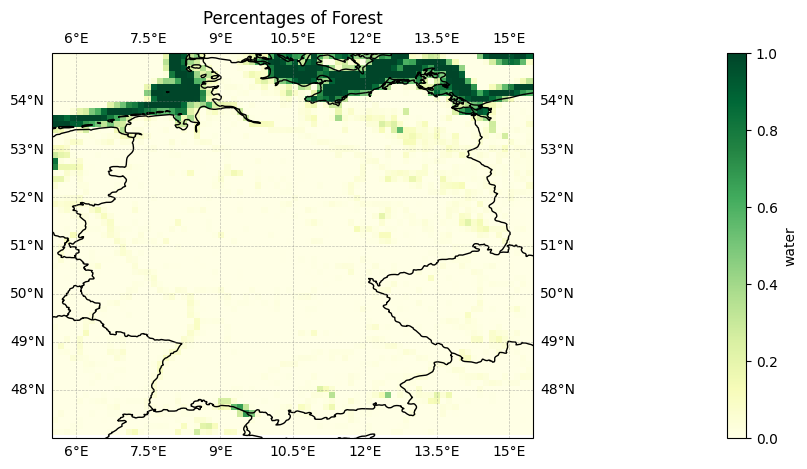

In [45]:
#Plotting
fig, ax = plt.subplots(1, 1, figsize=(50, 5), subplot_kw={'projection': ccrs.PlateCarree()}) 
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)


ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
ax.set_extent([5.5, 15.5, 47, 55], crs=ccrs.PlateCarree())
ds["water"].plot(cmap="YlGn", vmin=0, vmax=1)
plt.title("Percentages of Forest")
plt.show()

In [ ]:
#Export Data Array
ds.to_netcdf(output_path)